<a href="https://colab.research.google.com/github/fanxu30/XAI/blob/main/assn_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Explainable Techniques II
Fan Xu

In [ ]:
!pip install alibi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from alibi.explainers import ALE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Load dataset
boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame
X, y = df.drop('MEDV', axis=1), df['MEDV']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print(f"R² Score: {r2_score(y_test, rf.predict(X_test)):.3f}")

R² Score: 0.892


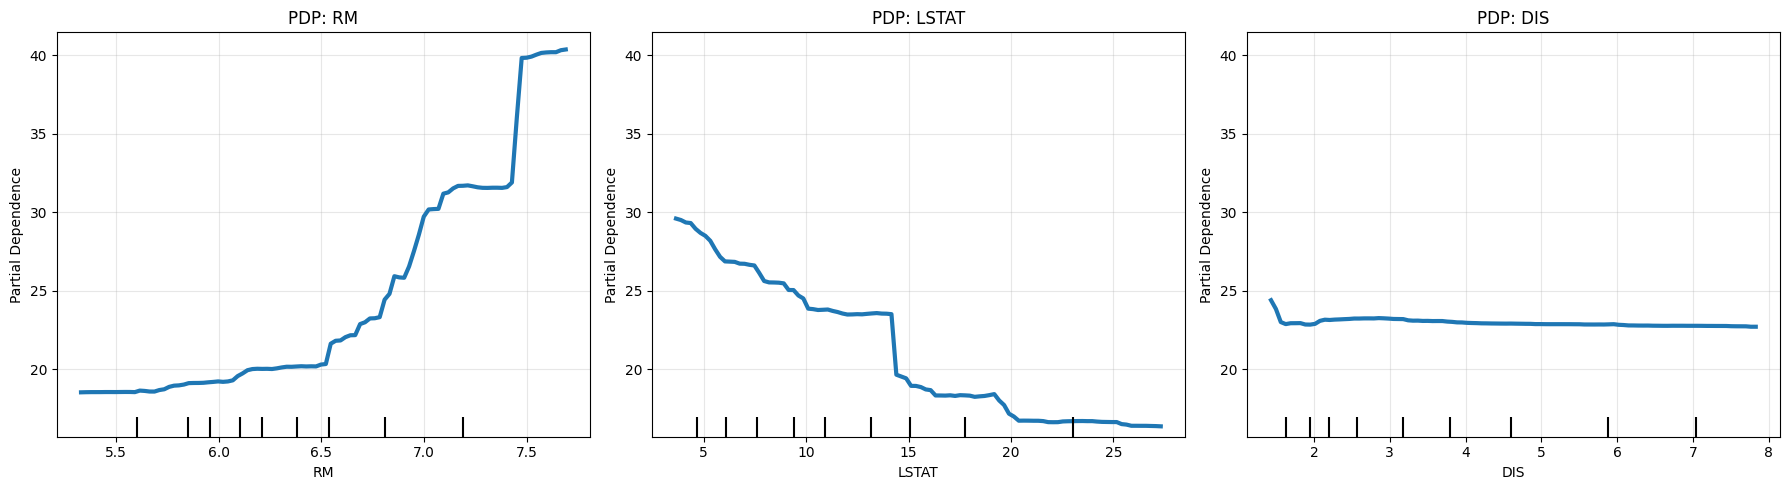

In [3]:
# PDP plots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

features = ['RM', 'LSTAT', 'DIS']
PartialDependenceDisplay.from_estimator(
    rf, X_train, features,
    ax=ax, line_kw={'linewidth': 3}
)

for i, feature in enumerate(features):
    ax[i].set_title(f'PDP: {feature}')
    ax[i].set_ylabel('Partial Dependence')
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

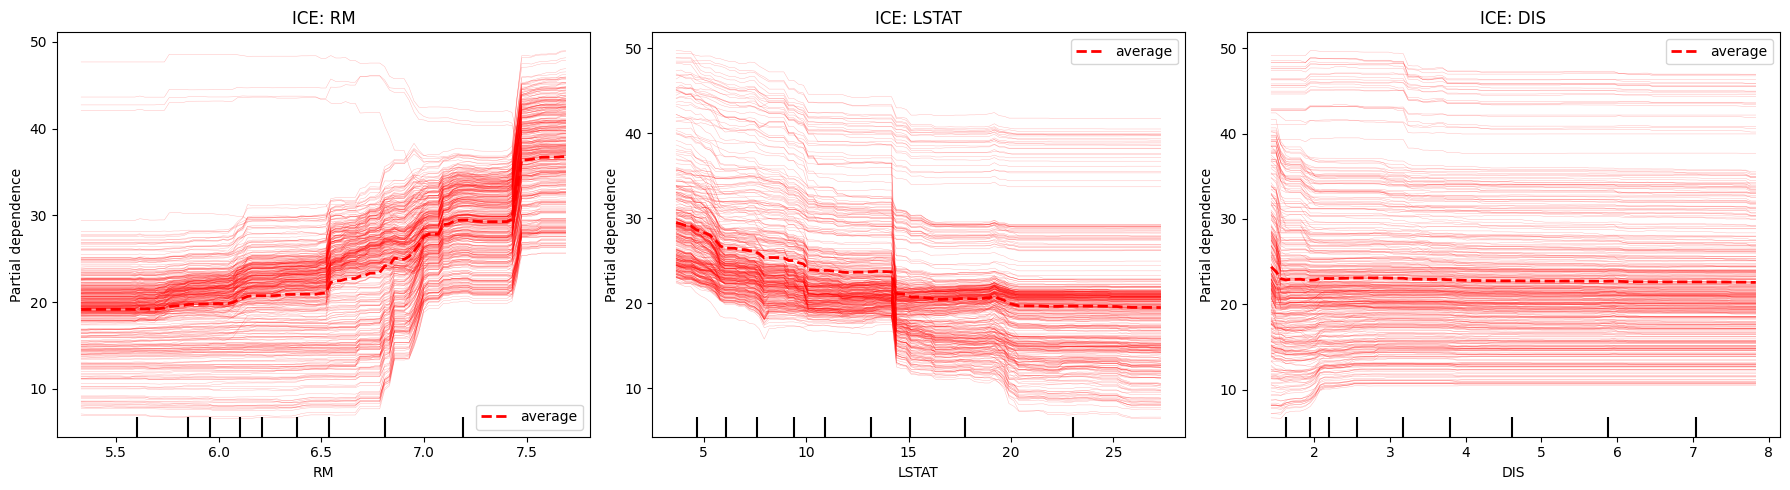

In [4]:
# ICE plots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        rf, X_train, [feature],
        ax=ax[i], kind='both',
        line_kw={'linewidth': 2, 'color': 'red'},
        ice_lines_kw={'linewidth': 0.3, 'alpha': 0.3}
    )
    ax[i].set_title(f'ICE: {feature}')
    ax[i].set_ylabel('Predicted MEDV')
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Generating PDP and ICE plots...


/tmp/ipython-input-369500243.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
/tmp/ipython-input-369500243.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
/tmp/ipython-input-369500243.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
/tmp/ipython-input-369500243.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
/tmp/ipython-input-369500243.py:21: UserWarning: No artists with labels found to put in legend.  Not

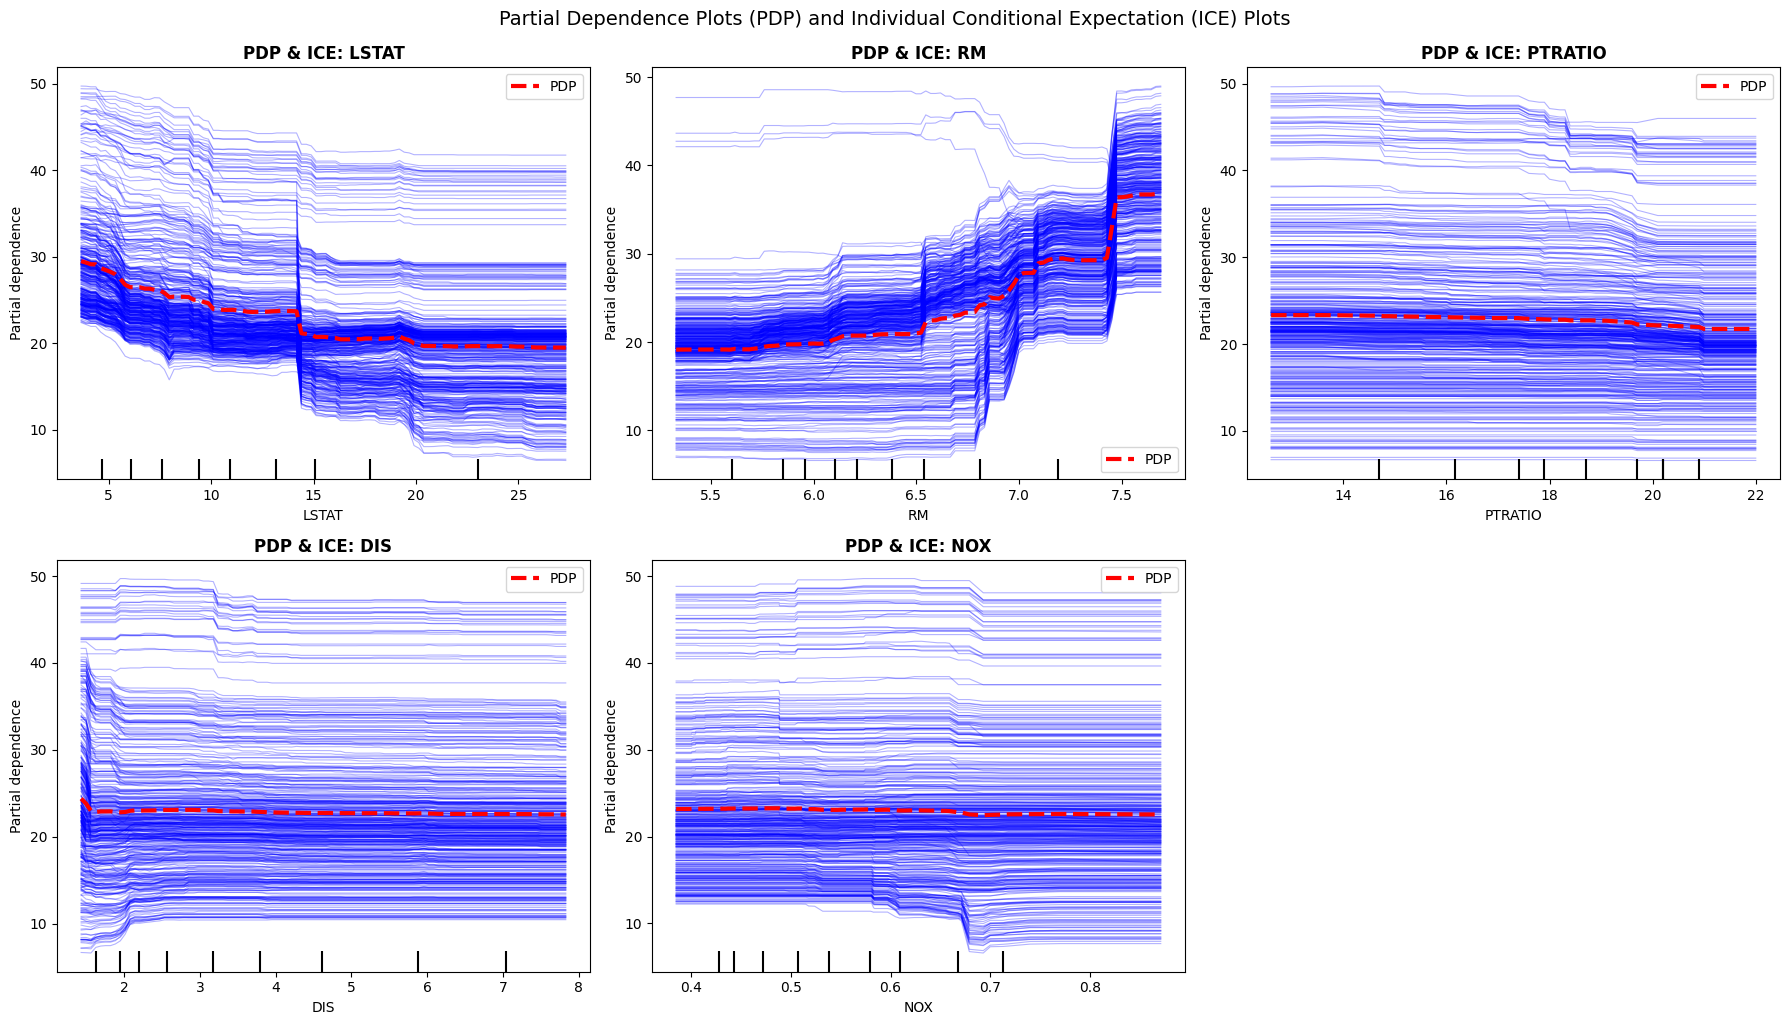

In [16]:
# Select key features for analysis based on correlation with target
key_features = ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX']

# PDP plots
print("Generating PDP and ICE plots...")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    if i < len(axes):
        PartialDependenceDisplay.from_estimator(
            rf, X_train, [feature],
            ax=axes[i], kind='both',
            line_kw={'linewidth': 3, 'color': 'red', 'label': 'PDP'},
            ice_lines_kw={'linewidth': 0.8, 'alpha': 0.3, 'color': 'blue'},
            pd_line_kw={'linewidth': 3, 'color': 'red'}
        )
        axes[i].set_title(f'PDP & ICE: {feature}', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Predicted MEDV ($1000s)')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()

# Remove empty subplots
for i in range(len(key_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) Plots',
             fontsize=14, y=1.02)
plt.show()

Installing PyALE...


INFO:PyALE._ALE_generic:Continuous feature detected.


Generating ALE plots...


INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.


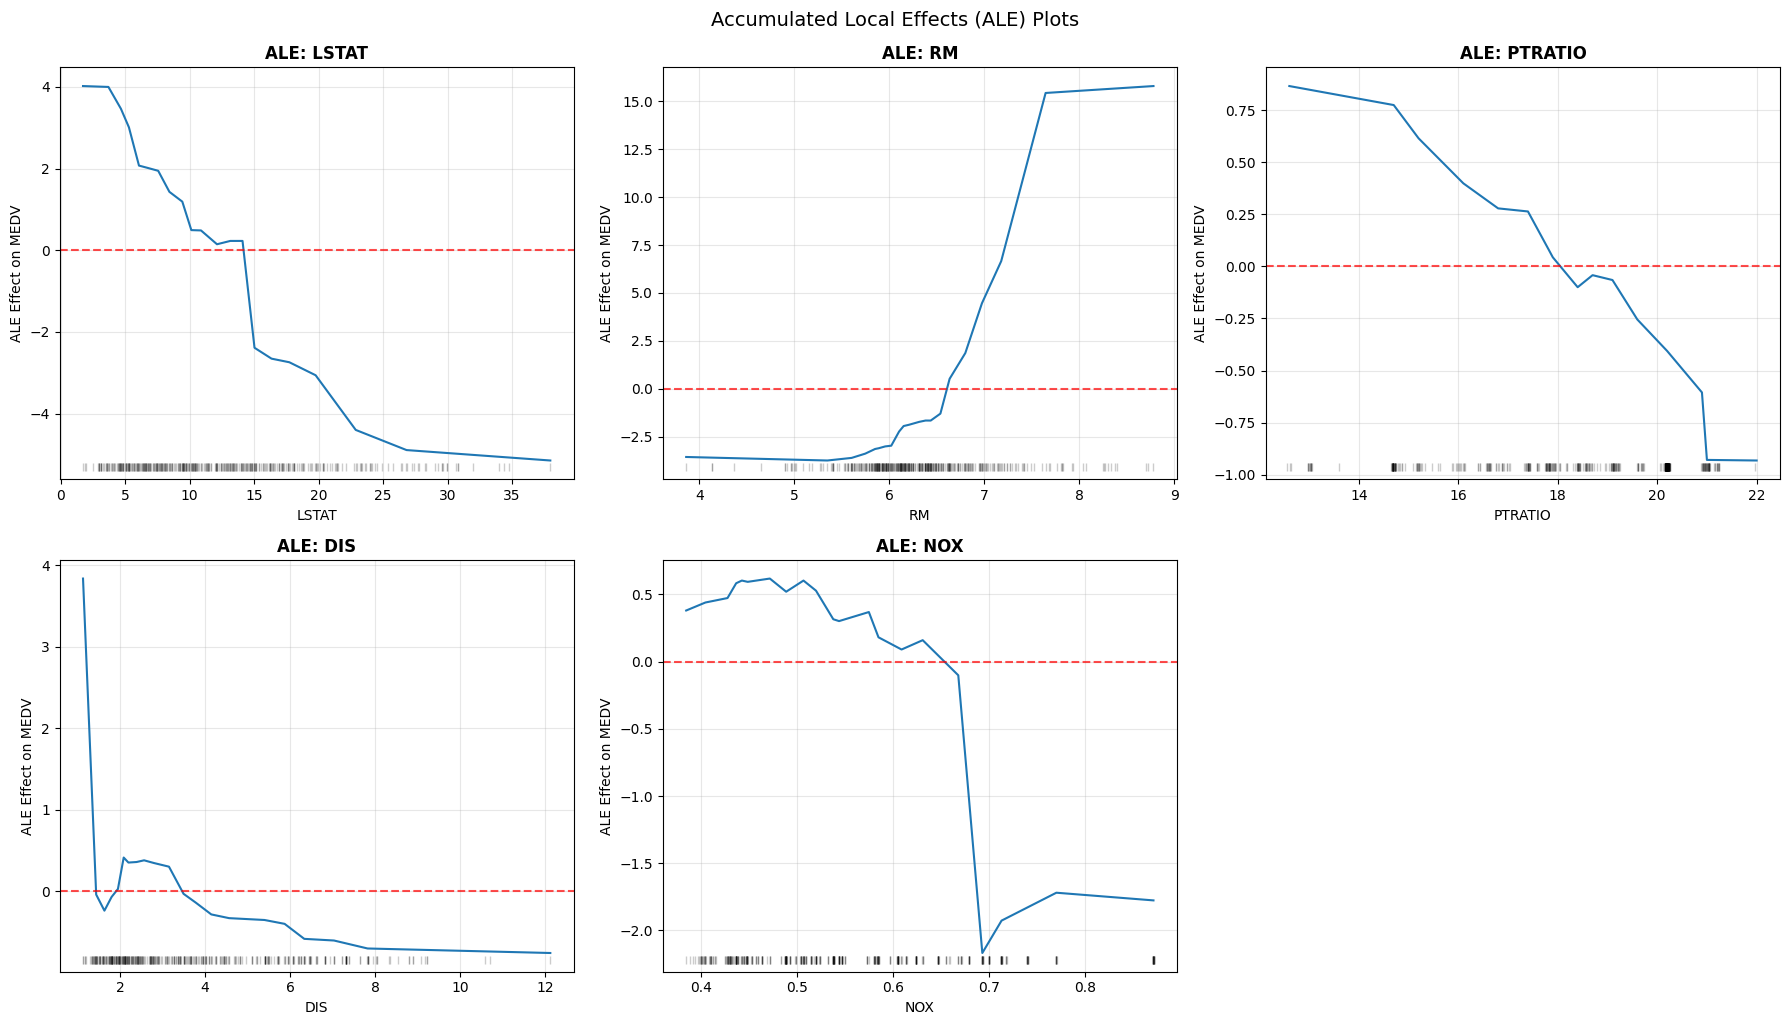

In [17]:
# Install PyALE if not available
try:
    import PyALE
except ImportError:
    print("Installing PyALE...")
    !pip install PyALE
    import PyALE

# Generate ALE plots
print("Generating ALE plots...")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    if i < len(axes):
        # Use PyALE for ALE plots
        ale_eff = PyALE.ale(
            X=X_train,
            model=rf,
            feature=[feature],
            include_CI=False,
            fig=fig,
            ax=axes[i]
        )
        axes[i].set_title(f'ALE: {feature}', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('ALE Effect on MEDV')
        axes[i].grid(True, alpha=0.3)

        # Add horizontal line at y=0 for reference
        axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.7)

# Remove empty subplots
for i in range(len(key_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Accumulated Local Effects (ALE) Plots', fontsize=14, y=1.02)
plt.show()